# Overview

For this project, we’ll use a dataset that tracks the level of solar radiation. The dataset is openly available from the OpenML Repository: https://www.openml.org/search?type=data&status=active&id=43751.

The objective of this project is to create a model that can forecast the next 24 hours of solar radiation.

In [55]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

Set a random seed to ensure that the results can be reproduced.

In [56]:
tf.random.set_seed(42)
np.random.seed(42)

# Data Exploring and Preprocessing

Fetch data from OpenML.

In [57]:
from sklearn.datasets import fetch_openml

solar = fetch_openml(data_id=43751)
df = solar.frame
df

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00
...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,12/1/2016 12:00:00 AM,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00
32682,1480587301,12/1/2016 12:00:00 AM,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00
32683,1480587001,12/1/2016 12:00:00 AM,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00
32684,1480586702,12/1/2016 12:00:00 AM,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00


In [58]:
pred_column = 'Radiation'

## Makeing datetime feature

In [59]:
# make a datetime column
df['date'] = pd.to_datetime(df['UNIXTime'] - 10*60*60, unit='s', origin='unix')
df

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,date
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,2016-09-29 23:55:26
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,2016-09-29 23:50:23
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,2016-09-29 23:45:26
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,2016-09-29 23:40:21
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,2016-09-29 23:35:24
...,...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,12/1/2016 12:00:00 AM,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00,2016-12-01 00:20:04
32682,1480587301,12/1/2016 12:00:00 AM,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00,2016-12-01 00:15:01
32683,1480587001,12/1/2016 12:00:00 AM,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00,2016-12-01 00:10:01
32684,1480586702,12/1/2016 12:00:00 AM,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00,2016-12-01 00:05:02


Sort the dataset by datetime and reset the index.

In [60]:
# sort by date and re-index the dataset
df = df.sort_values(by=['date'], ascending=True).reset_index(drop=True)

In [61]:
# drop columns don't need them anymore
df = df.drop(columns=['UNIXTime', 'Data', 'Time'])
df

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,date
0,2.58,51,30.43,103,77.27,11.25,06:07:00,18:38:00,2016-09-01 00:00:08
1,2.83,51,30.43,103,153.44,9.00,06:07:00,18:38:00,2016-09-01 00:05:10
2,2.16,51,30.43,103,142.04,7.87,06:07:00,18:38:00,2016-09-01 00:20:06
3,2.21,51,30.43,103,144.12,18.00,06:07:00,18:38:00,2016-09-01 00:25:05
4,2.25,51,30.43,103,67.42,11.25,06:07:00,18:38:00,2016-09-01 00:30:09
...,...,...,...,...,...,...,...,...,...
32681,1.22,41,30.34,83,238.94,6.75,06:57:00,17:54:00,2016-12-31 23:35:02
32682,1.21,41,30.34,82,236.79,5.62,06:57:00,17:54:00,2016-12-31 23:40:01
32683,1.21,42,30.34,81,218.28,7.87,06:57:00,17:54:00,2016-12-31 23:45:04
32684,1.19,41,30.34,80,215.23,7.87,06:57:00,17:54:00,2016-12-31 23:50:03


## Handling non-numeric data

In [62]:
# convert "TimeSunRise" and "TimeSunSet" to integer: second of the day
from datetime import datetime

pt = [datetime.strptime(x,'%H:%M:%S') for x in df['TimeSunRise']]  
df['TimeSunRise'] = [x.second + x.minute*60 + x.hour*360 for x in pt]
df

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,date
0,2.58,51,30.43,103,77.27,11.25,2580,18:38:00,2016-09-01 00:00:08
1,2.83,51,30.43,103,153.44,9.00,2580,18:38:00,2016-09-01 00:05:10
2,2.16,51,30.43,103,142.04,7.87,2580,18:38:00,2016-09-01 00:20:06
3,2.21,51,30.43,103,144.12,18.00,2580,18:38:00,2016-09-01 00:25:05
4,2.25,51,30.43,103,67.42,11.25,2580,18:38:00,2016-09-01 00:30:09
...,...,...,...,...,...,...,...,...,...
32681,1.22,41,30.34,83,238.94,6.75,5580,17:54:00,2016-12-31 23:35:02
32682,1.21,41,30.34,82,236.79,5.62,5580,17:54:00,2016-12-31 23:40:01
32683,1.21,42,30.34,81,218.28,7.87,5580,17:54:00,2016-12-31 23:45:04
32684,1.19,41,30.34,80,215.23,7.87,5580,17:54:00,2016-12-31 23:50:03


In [63]:
pt = [datetime.strptime(x, '%H:%M:%S') for x in df['TimeSunSet']]
df['TimeSunSet'] = [x.second + x.minute * 60 + x.hour * 360 for x in pt]
df

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,date
0,2.58,51,30.43,103,77.27,11.25,2580,8760,2016-09-01 00:00:08
1,2.83,51,30.43,103,153.44,9.00,2580,8760,2016-09-01 00:05:10
2,2.16,51,30.43,103,142.04,7.87,2580,8760,2016-09-01 00:20:06
3,2.21,51,30.43,103,144.12,18.00,2580,8760,2016-09-01 00:25:05
4,2.25,51,30.43,103,67.42,11.25,2580,8760,2016-09-01 00:30:09
...,...,...,...,...,...,...,...,...,...
32681,1.22,41,30.34,83,238.94,6.75,5580,9360,2016-12-31 23:35:02
32682,1.21,41,30.34,82,236.79,5.62,5580,9360,2016-12-31 23:40:01
32683,1.21,42,30.34,81,218.28,7.87,5580,9360,2016-12-31 23:45:04
32684,1.19,41,30.34,80,215.23,7.87,5580,9360,2016-12-31 23:50:03


## Resampling

In [64]:
# resample the dataset to 1 hour interval
df = df.resample('1h', on='date').mean()
df

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
date,,,,,,,,
2016-09-01 00:00:00,2.288750,51.125000,30.430000,103.000000,109.837500,8.857500,2580.0,8760.0
2016-09-01 01:00:00,2.943333,51.500000,30.417500,103.000000,121.345833,5.246667,2580.0,8760.0
2016-09-01 02:00:00,2.733333,51.000000,30.404167,103.000000,136.402500,9.653333,2580.0,8760.0
2016-09-01 03:00:00,2.344545,50.818182,30.400000,102.636364,89.257273,5.520909,2580.0,8760.0
2016-09-01 04:00:00,2.607500,49.083333,30.407500,102.000000,118.165833,7.965833,2580.0,8760.0
...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,1.221667,46.166667,30.327500,93.666667,285.428333,5.997500,5580.0,9360.0
2016-12-31 20:00:00,1.216667,44.166667,30.337500,87.083333,231.082500,5.435000,5580.0,9360.0
2016-12-31 21:00:00,1.225833,41.833333,30.343333,83.333333,213.929167,7.404167,5580.0,9360.0


In [65]:
# Define a function for ploting the dataset
def plot_data(df, plot_cols = ['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed', 'TimeSunRise', 'TimeSunSet']):
    plot_features = df[plot_cols]
    plot_features.index = df.index
    _ = plot_features.plot(subplots=True)
    
    plot_features = df[plot_cols][:480]
    plot_features.index = df.index[:480]
    _ = plot_features.plot(subplots=True)

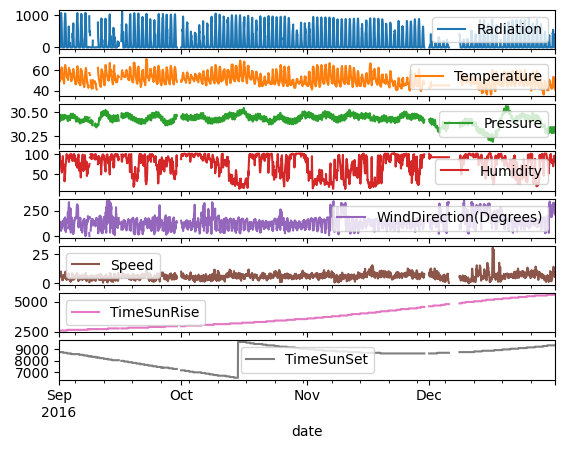

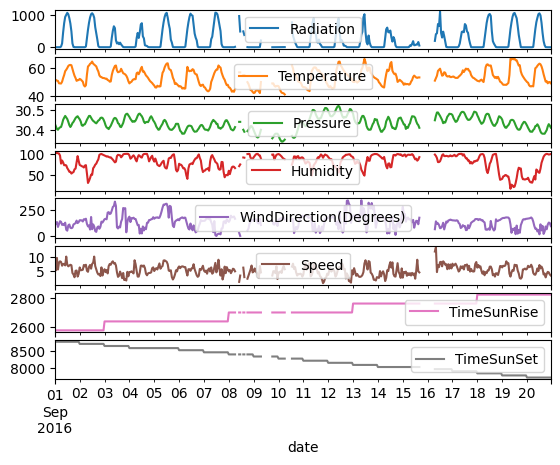

In [66]:
plot_data(df)

## Dealing with missing data

In [67]:
df.isna().sum()

Radiation                 151
Temperature               151
Pressure                  151
Humidity                  151
WindDirection(Degrees)    151
Speed                     151
TimeSunRise               151
TimeSunSet                151
dtype: int64

STL Decomposition for Time Series: This method breaks down the time series into trend, seasonality, and residuals, then imputes missing values in the residuals before reassembling the components. This could prove useful for time series data with a distinct trend and seasonality.

In [68]:
# function for imputing seasonal data
from statsmodels.tsa.seasonal import STL

def impute_missing_seasonal(df, columns):
    df_copy = df.copy()
    for c in columns:
        # Fill missing values in the time series
        imputed_indices = df[df[c].isnull()].index
        # Apply STL decompostion
        stl = STL(df_copy[c].interpolate(), seasonal=31)
        res = stl.fit()
        
        # Extract the seasonal and trend components
        seasonal_component = res.seasonal
        
        # Create the deseasonalised series
        df_deseasonalised = df_copy[c] - seasonal_component
        
        # Interpolate missing values in the deseasonalised series
        df_deseasonalised_imputed = df_deseasonalised.interpolate(method="linear")
        
        # Add the seasonal component back to create the final imputed series
        df_imputed = df_deseasonalised_imputed + seasonal_component
        
        # Update the original dataframe with the imputed values
        df_copy.loc[imputed_indices, c] = df_imputed[imputed_indices]
        
        # Plot the series using pandas
        plt.figure(figsize=[12, 6])
        df_copy[c].plot(style='.-',  label=c)
        plt.scatter(imputed_indices, df_copy.loc[imputed_indices, c], color='red')
        
        plt.title("{0} with STL Imputation".format(c))
        plt.ylabel(c)
        plt.xlabel("Time")
        plt.show()
    return df_copy   

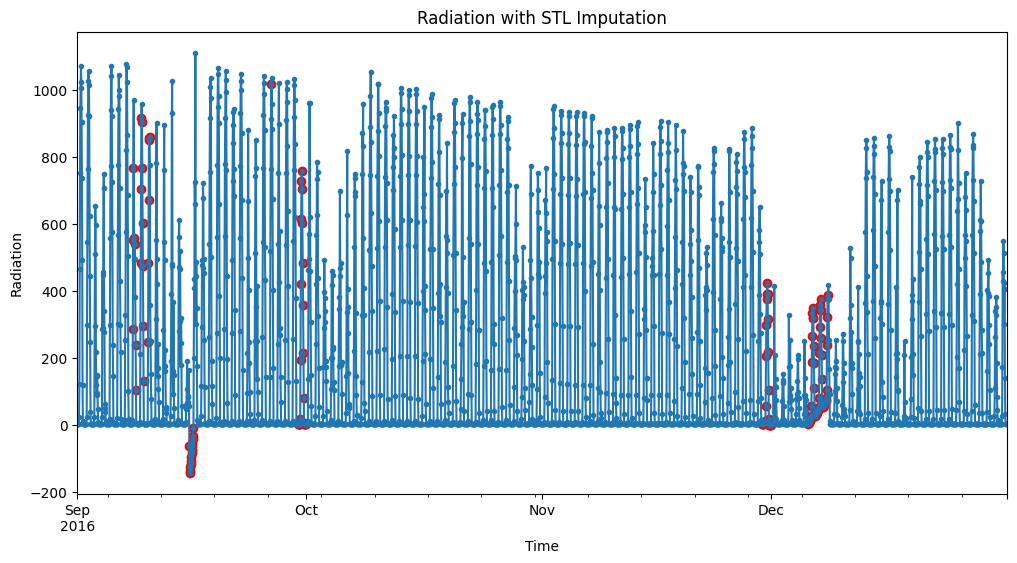

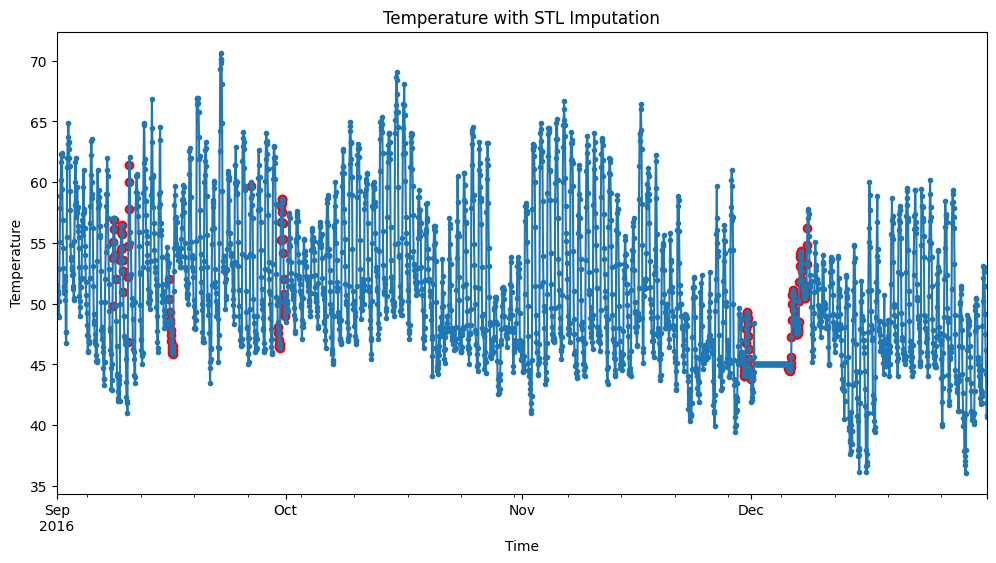

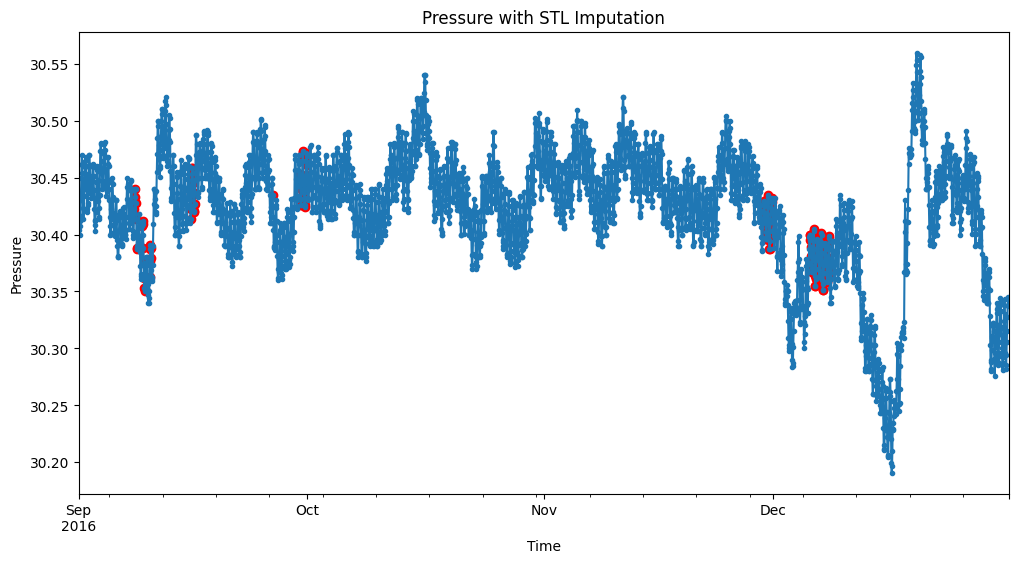

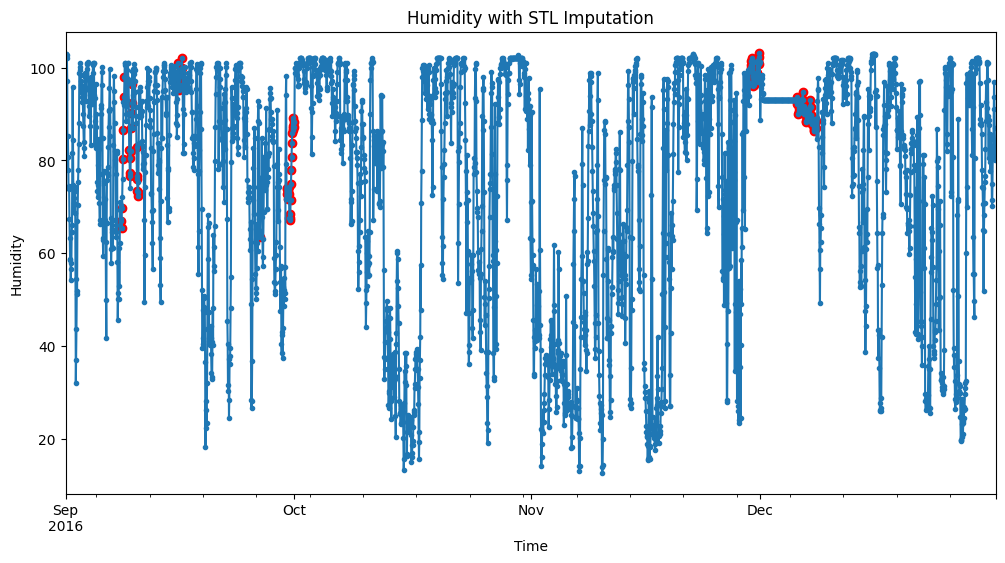

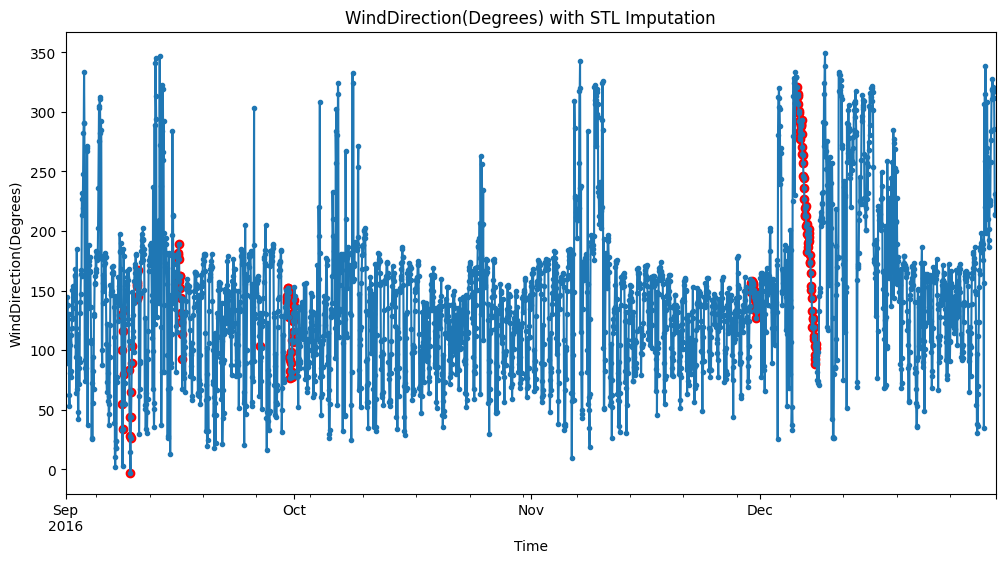

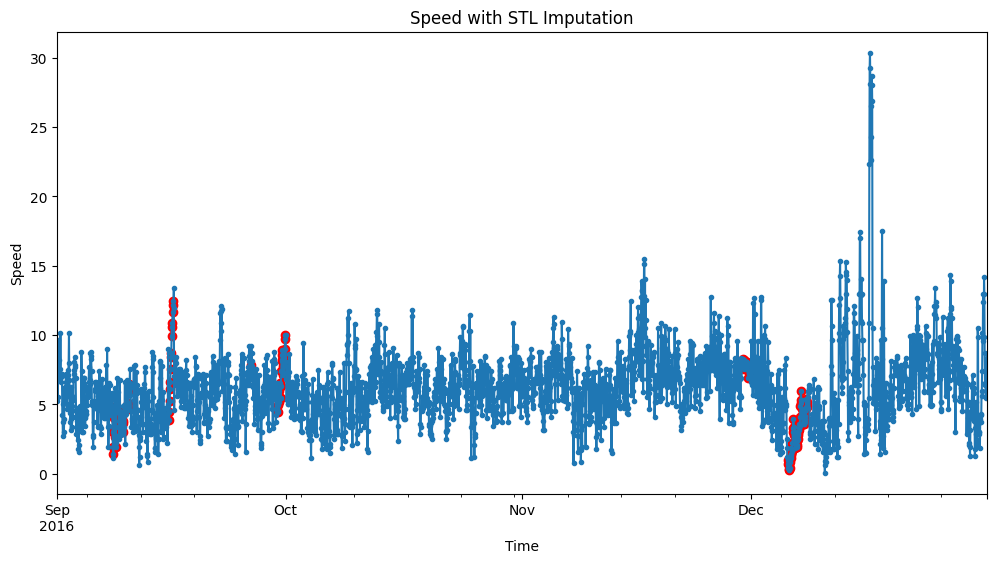

In [69]:
df = impute_missing_seasonal(df, columns=['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed'])

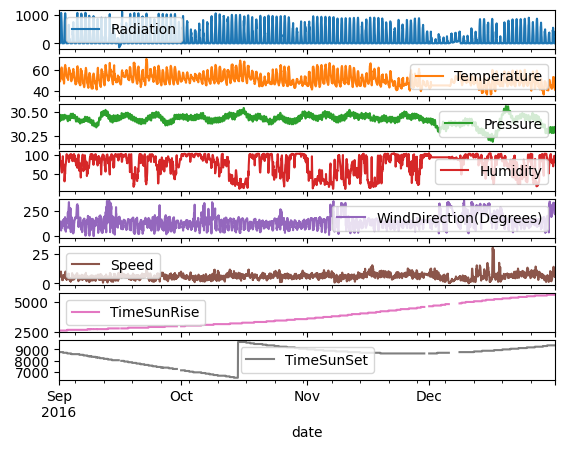

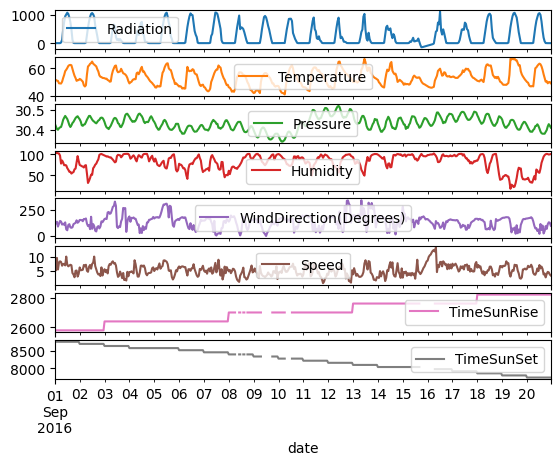

In [70]:
plot_data(df)

All columns look good except "Radiation".
Because Radiation must be >=0, so we take the absolute values of Radiation to make sure they all >= 0.

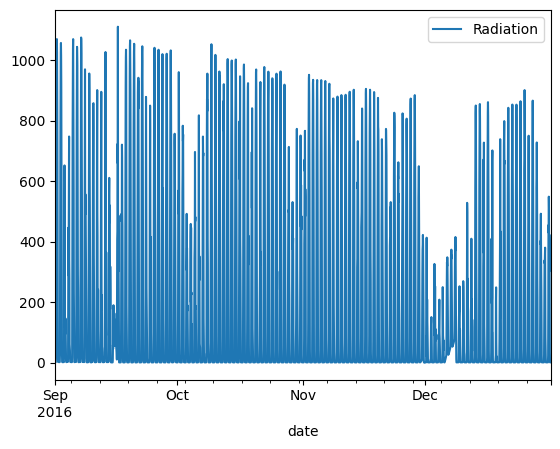

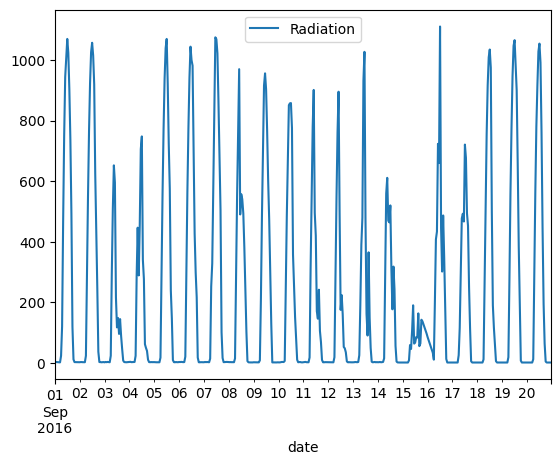

In [71]:
# convert all "Radiation" to positive values
df['Radiation'] = df['Radiation'].abs()
plot_data(df, plot_cols=['Radiation'])

In [72]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Radiation,2928.0,207.766305,304.949617,0.130143,1.228333,7.026975,368.770625,1111.011667
Temperature,2928.0,51.066114,6.060896,36.083333,46.500000,50.000000,55.000000,70.666667
Pressure,2928.0,30.421961,0.053459,30.190833,30.400000,30.430000,30.456667,30.560000
Humidity,2928.0,75.834242,25.160059,12.666667,57.979167,86.000000,96.666667,103.274082
WindDirection(Degrees),2928.0,143.994081,61.972130,-2.778259,103.003333,141.590417,170.417292,349.908333
Speed,2928.0,6.181699,2.622149,0.093333,4.591667,5.999583,7.497500,30.370833
TimeSunRise,2777.0,3801.001080,933.493334,2580.000000,3000.000000,3540.000000,4560.000000,5580.000000
TimeSunSet,2777.0,8477.954627,809.787299,6480.000000,8040.000000,8700.000000,9000.000000,9660.000000


Fill NaN of "TimeSunRise" and "TimeSunSet" by propagating the last valid observation to next valid.

In [73]:
# Fill missing values of "TimeSunRise" and "TimeSunSet" by last valid observation
df = df.ffill()
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Radiation,2928.0,207.766305,304.949617,0.130143,1.228333,7.026975,368.770625,1111.011667
Temperature,2928.0,51.066114,6.060896,36.083333,46.500000,50.000000,55.000000,70.666667
Pressure,2928.0,30.421961,0.053459,30.190833,30.400000,30.430000,30.456667,30.560000
Humidity,2928.0,75.834242,25.160059,12.666667,57.979167,86.000000,96.666667,103.274082
WindDirection(Degrees),2928.0,143.994081,61.972130,-2.778259,103.003333,141.590417,170.417292,349.908333
Speed,2928.0,6.181699,2.622149,0.093333,4.591667,5.999583,7.497500,30.370833
TimeSunRise,2928.0,3808.790984,934.723270,2580.000000,2940.000000,3570.000000,4620.000000,5580.000000
TimeSunSet,2928.0,8470.737705,798.007085,6480.000000,8040.000000,8700.000000,9000.000000,9660.000000


## Feature engineering

### Wind

The feature "WindDirection(Degrees)" gives the wind direction in units of degrees. Angles do not make good model inputs: 360° and 0° should be close to each other and wrap around smoothly. Direction shouldn't matter if the wind is not blowing.

Right now the distribution of wind data looks like this:

Text(0, 0.5, 'Wind Speed')

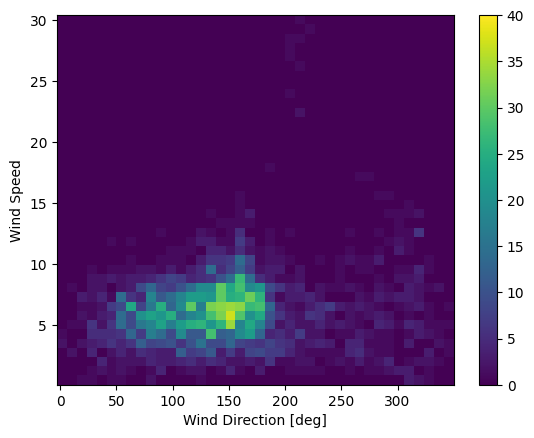

In [74]:
plt.hist2d(df['WindDirection(Degrees)'], df['Speed'], bins=(40, 40), vmax=40)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Speed')

But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind vector:

In [75]:
# convert wind direction and speed to wind vector
speed = df.pop('Speed')

# Convert to radians.
wd_rad = df.pop('WindDirection(Degrees)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = speed*np.cos(wd_rad)
df['Wy'] = speed*np.sin(wd_rad)

(-26.551356904849687,
 10.761976829797197,
 -19.059242496582993,
 12.472954133807654)

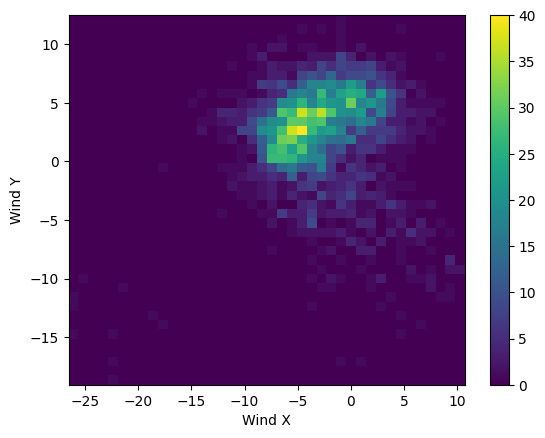

In [76]:
plt.hist2d(df['Wx'], df['Wy'], bins=(40, 40), vmax=40)
plt.colorbar()
plt.xlabel('Wind X')
plt.ylabel('Wind Y')
ax = plt.gca()
ax.axis('tight')

### Time

With our target being solar radiation, it is likely that we’ll have some seasonality. We can expect that at night, less solar radiation will be detected. Similarly, there may be a peak in the noon. Thus, it is reasonable to assume that there will be some seasonality in our target.
We can plot our target to see if we can visually detect the period.

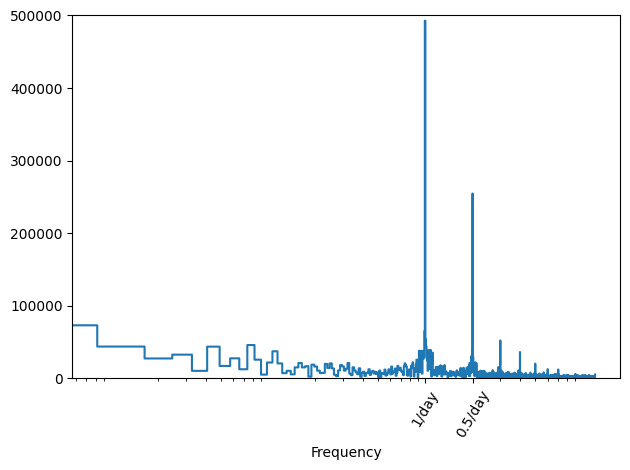

In [77]:
# Set daily seasonality
fft = tf.signal.rfft(df[pred_column])
f_per_dataset = np.arange(0, len(fft))
n_sample_h = len(df[pred_column])
hours_per_day = 24
day_per_dataset = n_sample_h / hours_per_day
f_per_day = f_per_dataset / day_per_dataset
plt.step(f_per_day, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 500000)
plt.xticks([1, 2], ['1/day', '0.5/day'], rotation=60)
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

You can see that there is a visible peak for the daily seasonality. This tells us that we indeed have daily seasonality in our data. Thus, we will encode our timestamp using a sine and cosine transformation to express the time while keeping its daily seasonal information.

In [78]:
# encode timestamp to sine and cosine
from datetime import datetime

timestamp_s = pd.to_datetime(df.index).map(datetime.timestamp)
day = 24 * 60 * 60
df['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values
df['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values

Text(0.5, 1.0, 'Time of day signal')

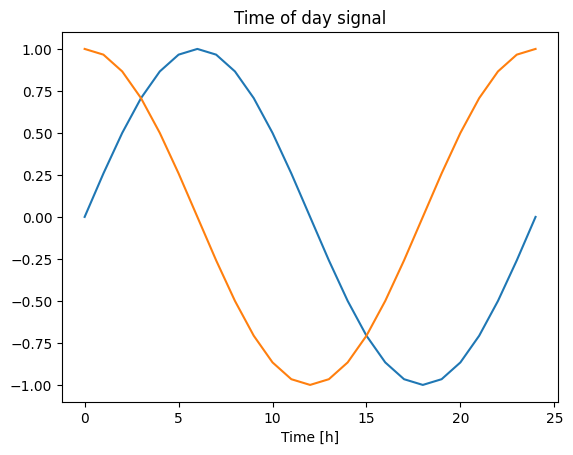

In [79]:
plt.plot(np.array(df['day_sin'])[:25])
plt.plot(np.array(df['day_cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

## Split the data

We’ll split the data 70:20:10 for the training, validation, and test sets respectively.

In [80]:
n = len(df)
# Split 70:20:10 (train:validation:test)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

## Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

In [81]:
# Normalize the data using training set
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Now, peek at the distribution of the features.

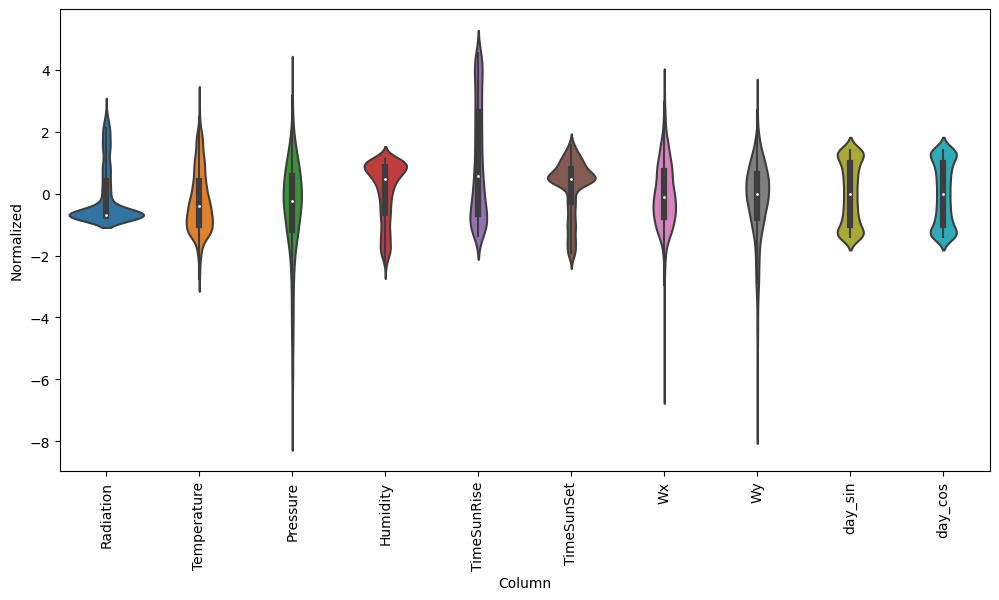

In [82]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

# Preparing for modeling with deep learning

We will build **two baselines**, a **linear model**, a **deep neural network model**, a **long short-term memory (LSTM) model**, a **convolutional neural network (CNN)**, a **combination of CNN and LSTM**, and finally an **autoregressive LSTM**. In the end, we will use the *mean absolute error (MAE)* to determine which model is the best. The one that achieves the lowest MAE on the test set will be the top-performing model.

Note that we’ll use the MAE as our evaluation metric and the mean squared error (MSE) as the loss function

### Defining the DataWindow class

The DataWindow class allows us to quickly create windows of data for training deep learning models. Each window of data contains a set of inputs and a set of labels. The model is then trained to produce predictions as close as possible to the labels using the inputs.

In [83]:
class DataWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col=pred_column, max_subplots=3):
        inputs, labels = self.sample_batch

        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time (h)')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )

        ds = ds.map(self.split_to_inputs_labels)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

### Utility function to train our models

In [84]:
# function that automates the training process
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')

    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])

    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])

    return history

In [85]:
# dictionary to store the column names and their corresponding indexes. 
column_indices = {name: i for i, name in enumerate(train_df.columns)}

# Modeling with deep learning

## Baseline models

Every forecasting project must start with a baseline model. Baselines serve as a benchmark for our more sophisticated models, as they can only be better in comparison to a certain benchmark. Building baseline models also allows us to assess whether the added complexity of a model really generates a significant benefit. It is possible that a complex model does not perform much better than a baseline, in which case implementing a complex model is hard to justify. In this case, we’ll build two baseline models: one that **repeats the last known value** and another that **repeats the last 24 hours of data**.

In [86]:
# the window of data that will be used
# the length of our label sequence is 24 timesteps, and the shift will also be 24 timesteps. 
# We’ll also use an input length of 24
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=[pred_column])

In [87]:
# repeat the last known value of the input sequence as a prediction for the next 24 hours
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

In [88]:
baseline_last = MultiStepLastBaseline(label_index=column_indices[pred_column])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(multi_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(multi_window.test, verbose=0)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5856 - mean_absolute_error: 1.3983  


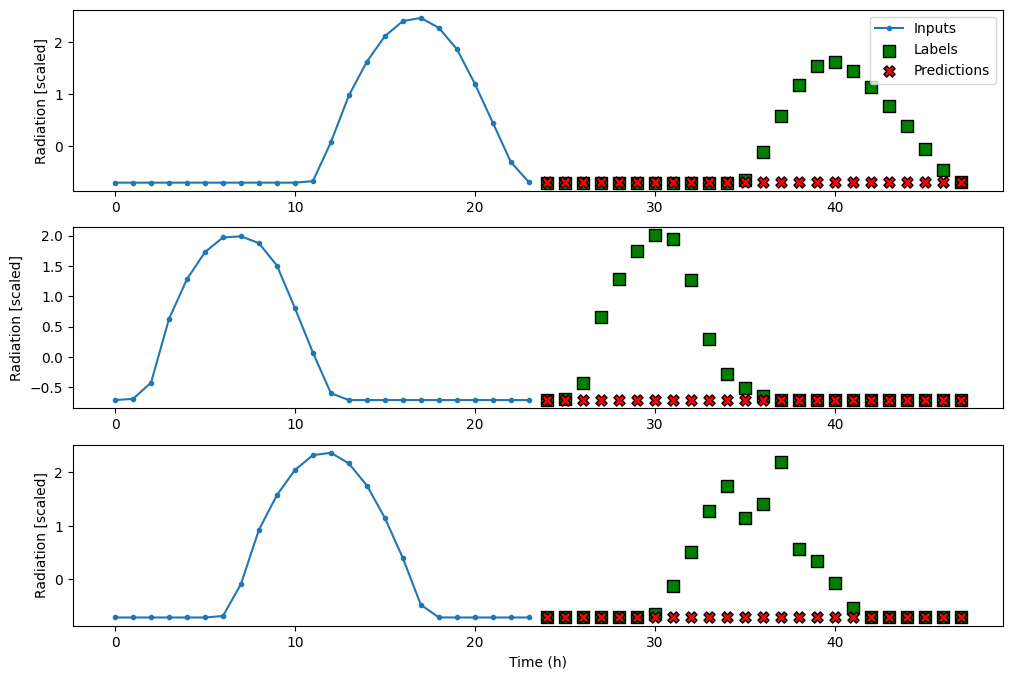

In [89]:
multi_window.plot(baseline_last)

In [90]:
# a baseline model that repeats the input sequence
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [91]:
baseline_repeat = RepeatBaseline(label_index=column_indices[pred_column])

baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.val)
performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.test, verbose=0)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2387 - mean_absolute_error: 1.3216  


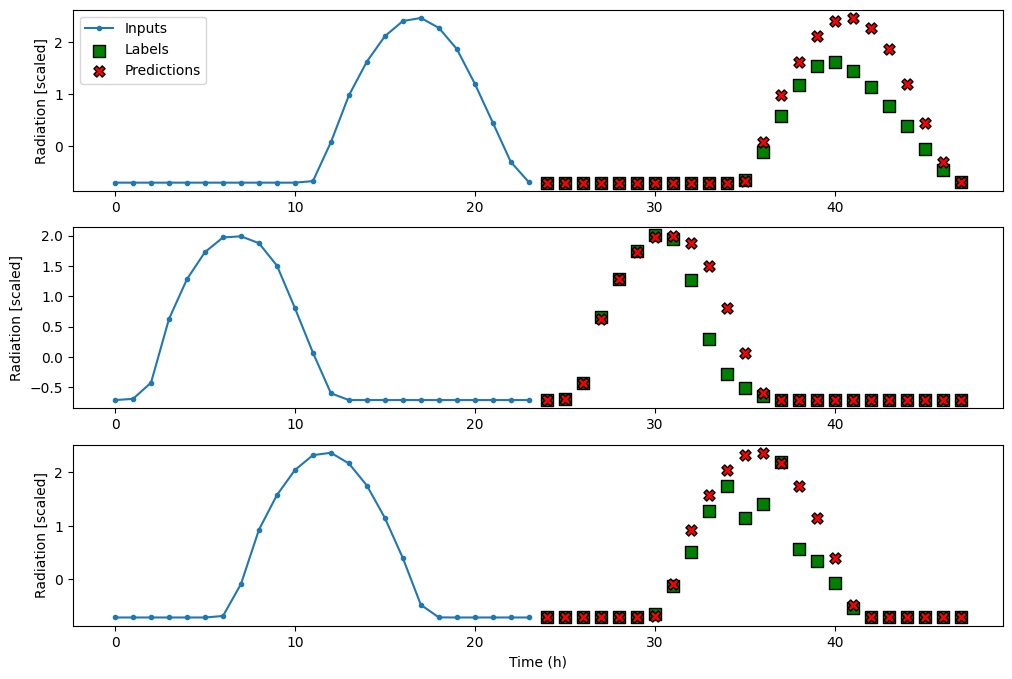

In [92]:
multi_window.plot(baseline_repeat)

You’ll see that the predictions are equal to the input sequence, which is the expected behavior for this baseline model.

##  Linear model

This model consists of only an input layer and an output layer. Thus, only a sequence of weights is computed to generate predictions that are as close as possible to the labels.

In [93]:
#  build a model with one Dense output layer that has only one neuron, since we are predicting only one target
linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(linear, multi_window)

val_performance['Linear'] = linear.evaluate(multi_window.val)
performance['Linear'] = linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.8955 - mean_absolute_error: 0.8009 - val_loss: 0.3139 - val_mean_absolute_error: 0.3960
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5699 - mean_absolute_error: 0.6210 - val_loss: 0.3070 - val_mean_absolute_error: 0.3559
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3899 - mean_absolute_error: 0.4887 - val_loss: 0.3120 - val_mean_absolute_error: 0.3666
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2955 - mean_absolute_error: 0.4060 - val_loss: 0.3053 - val_mean_absolute_error: 0.3742
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2553 - mean_absolute_error: 0.3666 - val_loss: 0.2919 - val_mean_absolute_error: 0.3752
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2279 - mean_absolute_error: 0.3451 - val_loss: 0.2703 - val_mean_absolute_error: 0.3669
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2171 - mean_absolute_error: 0.3368 - val_loss: 0.253

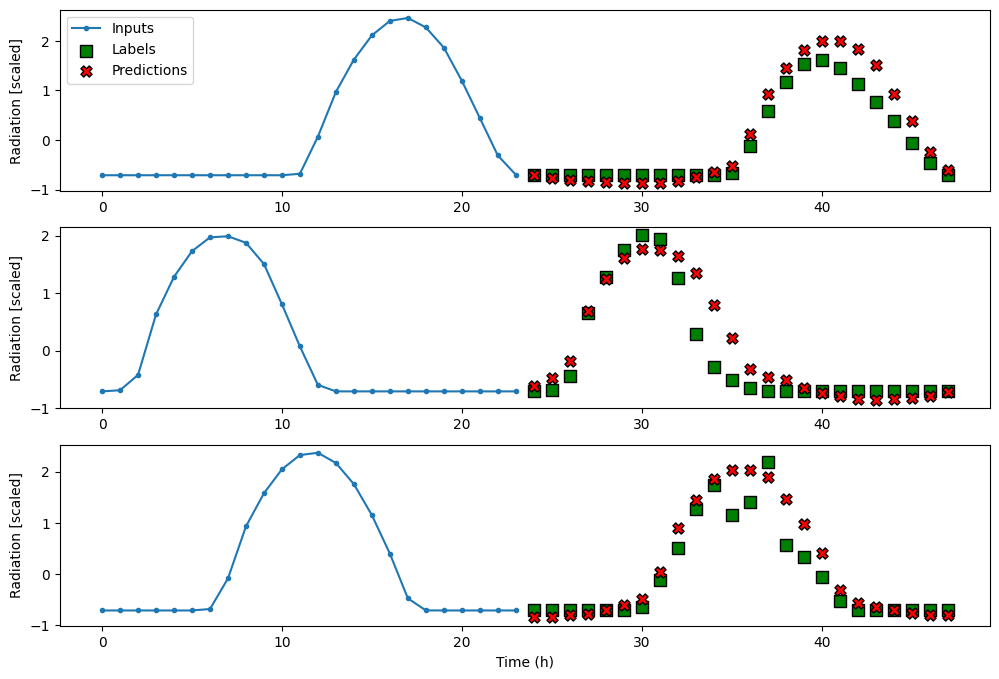

In [94]:
multi_window.plot(linear)

One advantage to linear models is that they're relatively simple to interpret. You can pull out the layer's weights and visualize the weight assigned to each input:

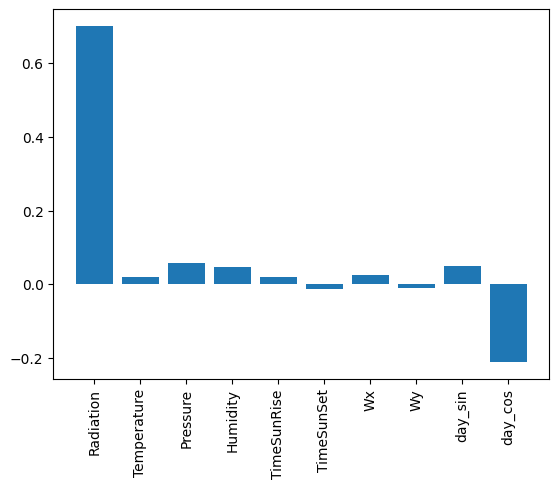

In [95]:
# plot layer's weight for each feature
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

##  Deep neural network

Here we’ll stack two Dense layers with 64 neurons and use ReLU as the activation function. Then we’ll train the model and
store its performance for comparison.

In [96]:
# stack 2 Dense layers with 64 neurons
dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(dense, multi_window)

val_performance['Dense'] = dense.evaluate(multi_window.val)
performance['Dense'] = dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.7069 - mean_absolute_error: 0.6753 - val_loss: 0.1819 - val_mean_absolute_error: 0.2856
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1409 - mean_absolute_error: 0.2251 - val_loss: 0.2131 - val_mean_absolute_error: 0.3290
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1245 - mean_absolute_error: 0.2019 - val_loss: 0.2356 - val_mean_absolute_error: 0.3514
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1161 - mean_absolute_error: 0.1931 - val_loss: 0.2405 - val_mean_absolute_error: 0.3564
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2333 - mean_absolute_error: 0.3528 


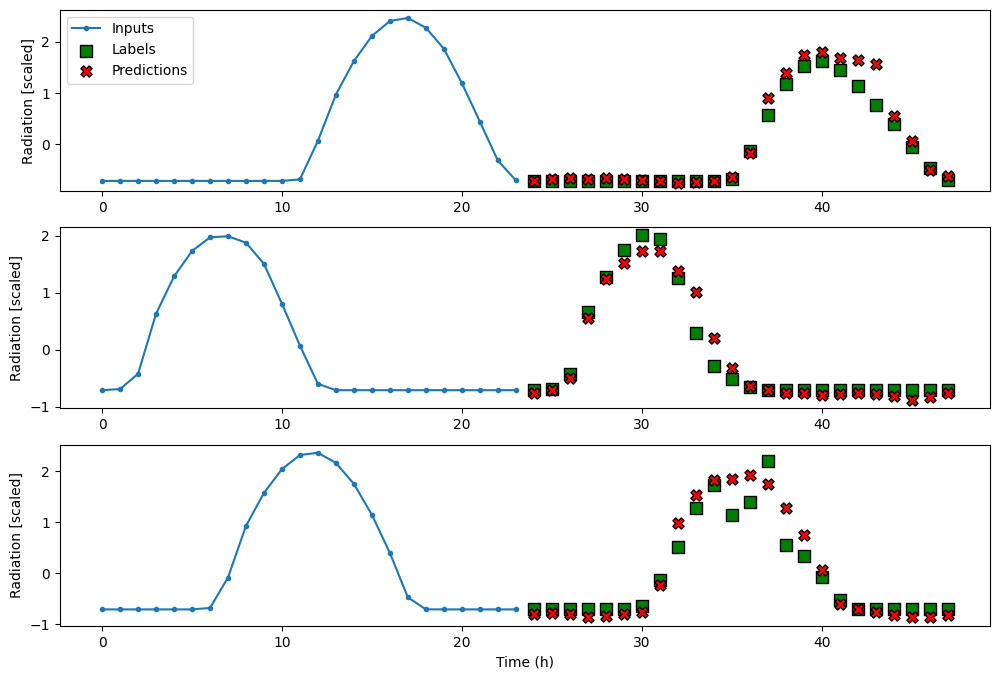

In [97]:
multi_window.plot(dense)

## Long short-term memory (LSTM) model

The main advantage of the long short-term memory (LSTM) model is that it keeps information from the past in memory. This makes it especially suitable for treating sequences of data, like time series. It allows us to combine information from the present and the past to produce a prediction.

We’ll feed the input sequence through an LSTM layer before sending it to the output layer, which remains a Dense layer with one neuron. We’ll then train the model and store its performance in the dictionary for comparison at the end.

In [98]:
# add a LSTM layer 
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(lstm_model, multi_window)

val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.8574 - mean_absolute_error: 0.7799 - val_loss: 0.2308 - val_mean_absolute_error: 0.3850
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1883 - mean_absolute_error: 0.3078 - val_loss: 0.1951 - val_mean_absolute_error: 0.3105
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1438 - mean_absolute_error: 0.2432 - val_loss: 0.1885 - val_mean_absolute_error: 0.2960
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1310 - mean_absolute_error: 0.2242 - val_loss: 0.1790 - val_mean_absolute_error: 0.2819
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1254 - mean_absolute_error: 0.2160 - val_loss: 0.1758 - val_mean_absolute_error: 0.2745
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1161 - mean_absolute_error: 0.2035 - val_loss: 0.1605 - val_mean_absolute_error: 0.2606
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1065 - mean_absolute_error: 0.1923 - val_loss

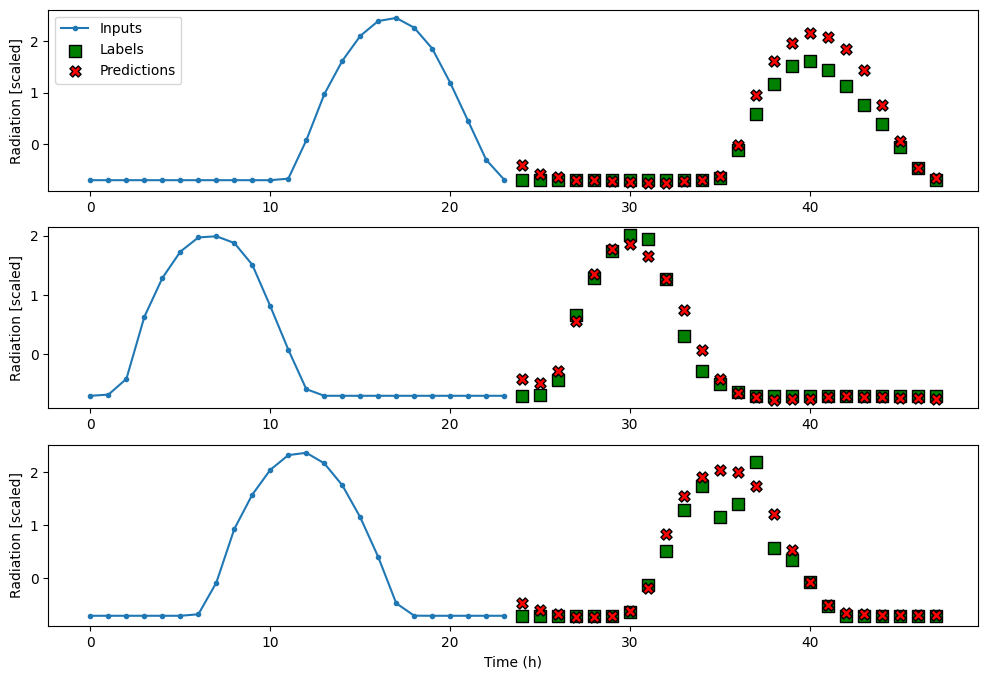

In [99]:
multi_window.plot(lstm_model)

## Convolutional neural network (CNN)

A convolutional neural network (CNN) uses the convolution function to reduce the feature space. This effectively filters our time series and performs feature selection. Furthermore, a CNN is faster to train than an LSTM since the operations are parallelized, whereas the LSTM must treat one element of the sequence at a time.

Because the convolution operation reduces the feature space, we must provide a slightly longer input sequence to make sure that the output sequence contains 24 timesteps. How much longer it needs to be depends on the length of the kernel that performs the convolution operation. In this case, we’ll use a kernel length of 3.

In [100]:
# Define CNN related variables
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

# Define window object for CNN
cnn_multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=[pred_column])

Next, we’ll send the input through a Conv1D layer, which filters the input sequence. Then it is fed to a Dense layer with 32 neurons for learning before going to the output layer.

In [101]:
# stack a Conv2D layer
cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_model, cnn_multi_window)

val_performance['CNN'] = cnn_model.evaluate(cnn_multi_window.val)
performance['CNN'] = cnn_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.7784 - mean_absolute_error: 0.7399 - val_loss: 0.1755 - val_mean_absolute_error: 0.2775
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1498 - mean_absolute_error: 0.2503 - val_loss: 0.1787 - val_mean_absolute_error: 0.3064
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1220 - mean_absolute_error: 0.2052 - val_loss: 0.1726 - val_mean_absolute_error: 0.2964
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1149 - mean_absolute_error: 0.1949 - val_loss: 0.1778 - val_mean_absolute_error: 0.3023
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1099 - mean_absolute_error: 0.1880 - val_loss: 0.1857 - val_mean_absolute_error: 0.3168
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1055 - mean_absolute_error: 0.1852 - val_loss: 0.1939 - val_mean_absolute_error: 0.3286
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1960 - mean_absolute_error: 0.3308 


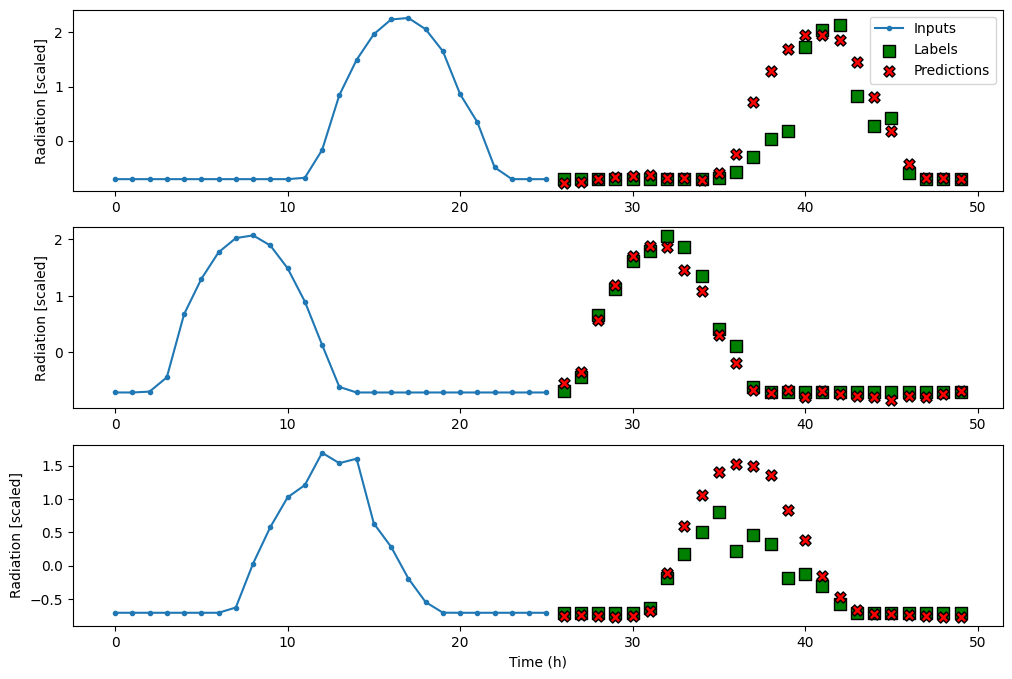

In [102]:
cnn_multi_window.plot(cnn_model)

## Combining a CNN with an LSTM

We know that LSTM is good at treating sequences of data, while CNN can filter a sequence of data. Therefore, it is interesting to test whether filtering a sequence before feeding it to an LSTM can result in a better-performing model.

We’ll feed the input sequence to a Conv1D layer, but use an LSTM layer for learning this time. Then we’ll send the information to the output layer. Again, we’ll train the model and store its performance.

In [103]:
# add Conv1D + LSTM layers
cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_lstm_model, cnn_multi_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.8095 - mean_absolute_error: 0.7443 - val_loss: 0.2507 - val_mean_absolute_error: 0.2988
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1411 - mean_absolute_error: 0.2417 - val_loss: 0.2148 - val_mean_absolute_error: 0.2676
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1177 - mean_absolute_error: 0.2031 - val_loss: 0.2289 - val_mean_absolute_error: 0.2772
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1021 - mean_absolute_error: 0.1861 - val_loss: 0.2203 - val_mean_absolute_error: 0.2713
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0928 - mean_absolute_error: 0.1750 - val_loss: 0.2203 - val_mean_absolute_error: 0.2712
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2132 - mean_absolute_error: 0.2670


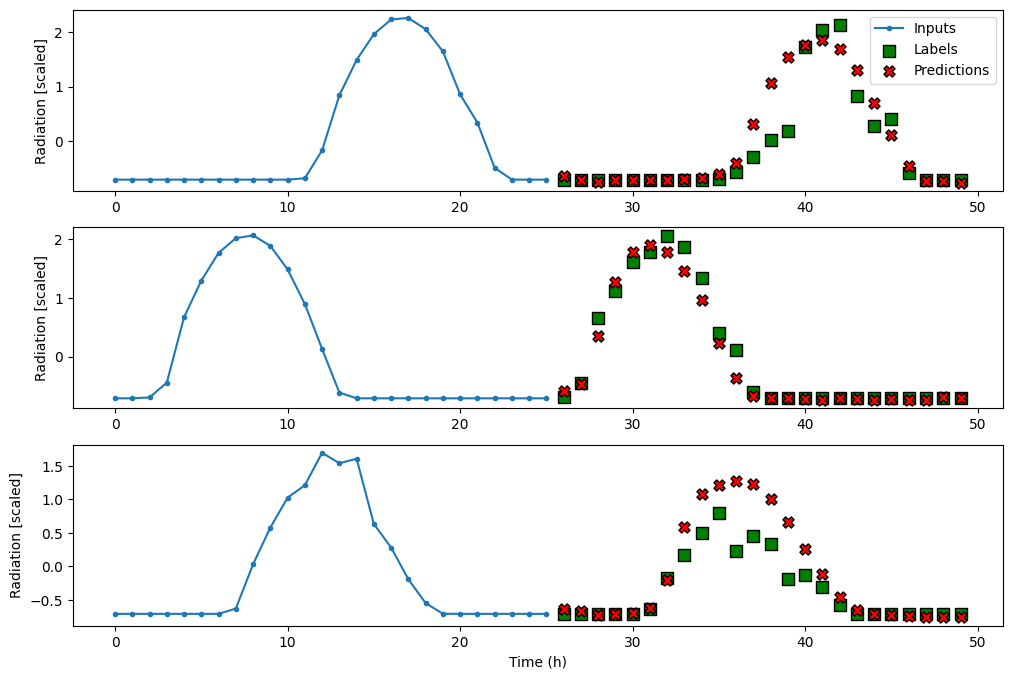

In [104]:
cnn_multi_window.plot(cnn_lstm_model)

## The autoregressive LSTM model

The final model that we’ll implement is an autoregressive LSTM (ARLSTM) model. Instead of generating the entire output sequence in a single shot, the autoregressive model will generate one prediction at a time and use that prediction as an input to generate the next one. This kind of architecture is present in state-of-the-art forecasting models, but it comes with a caveat.

If the model generates a very bad first prediction, this mistake will be carried on to the next predictions, which will magnify the errors. Nevertheless, it is worth testing this model to see if it works well in our situation.

In [105]:
# implement ARLSTM model
class AutoRegressive(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(train_df.shape[1])

    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)

        return prediction, state

    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)

        predictions.append(prediction)

        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)

            prediction = self.dense(x)
            predictions.append(prediction)

        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])

        return predictions

In [106]:
AR_LSTM = AutoRegressive(units=32, out_steps=24)

history = compile_and_fit(AR_LSTM, multi_window)

val_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.val)
performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - loss: 0.8923 - mean_absolute_error: 0.7876 - val_loss: 0.6090 - val_mean_absolute_error: 0.5890
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2651 - mean_absolute_error: 0.3755 - val_loss: 0.5175 - val_mean_absolute_error: 0.4994
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.1603 - mean_absolute_error: 0.2739 - val_loss: 0.4610 - val_mean_absolute_error: 0.4622
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1418 - mean_absolute_error: 0.2504 - val_loss: 0.4131 - val_mean_absolute_error: 0.4318
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.1352 - mean_absolute_error: 0.2386 - val_loss: 0.4335 - val_mean_absolute_error: 0.4369
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1286 - mean_absolute_error: 0.2297 - val_loss: 0.3776 - val_mean_absolute_error: 0.4063
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1206 - mean_absolute_error: 0.2207 - val_los

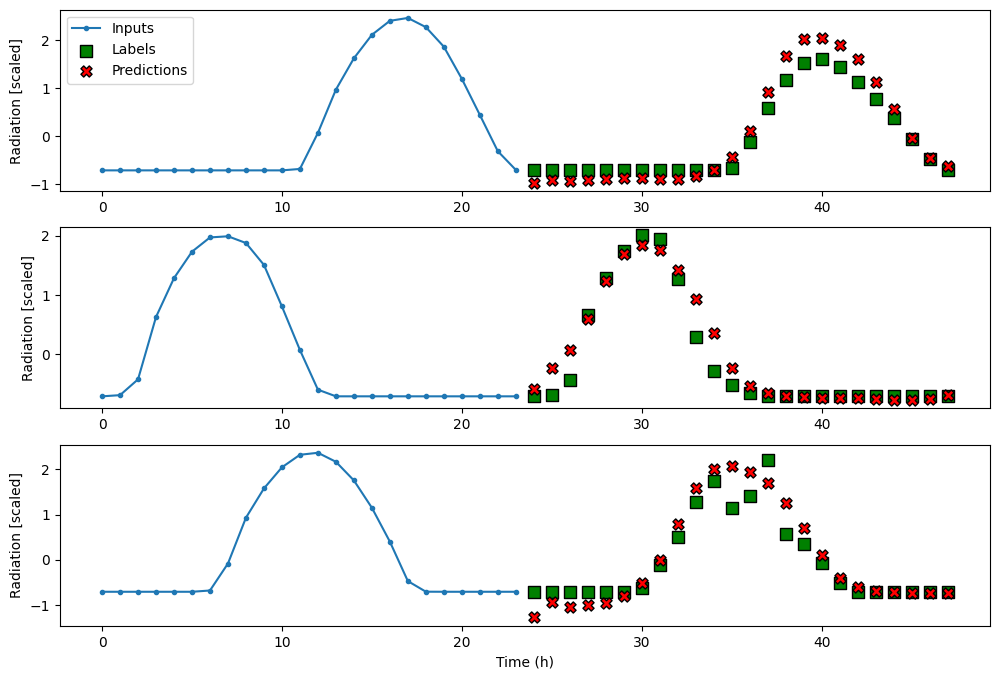

In [107]:
multi_window.plot(AR_LSTM)

## Selecting the best model

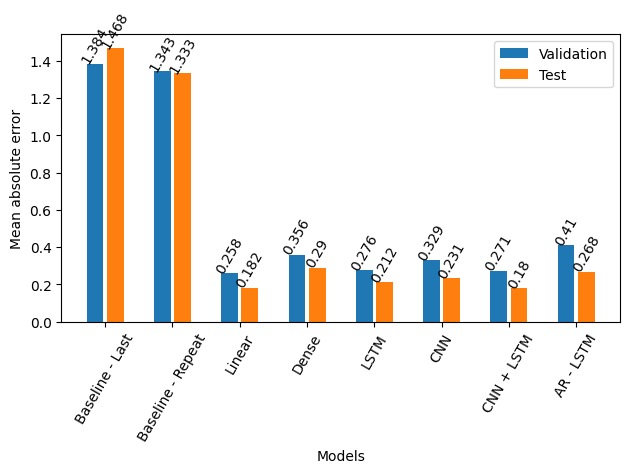

In [108]:
# plot the MAE on both the validation and test sets
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.005, s=str(round(value, 3)), ha='center', rotation=60)

for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center', rotation=60)

plt.xticks(ticks=x, labels=performance.keys(), rotation=60)
plt.legend(loc='best')
plt.tight_layout()

# Summary

# Reference

https://www.openml.org/search?type=data&status=active&id=43751

https://www.tensorflow.org/tutorials/structured_data/time_series

https://medium.com/@aaabulkhair/data-imputation-demystified-time-series-data-69bc9c798cb7

Marco Peixeiro, "Time Series Forecasting in Python", Manning Publications, 2022
